### Manmeet Singh 013906919

Assignment 2 Part I: Write autodiff python library and based on it, do  mnist classifier (similar to last exercise but using autodiff library  that you will write instead of direct numpy)

In [0]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader

%matplotlib inline
np.random.seed(0)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
X_train.shape

(60000, 28, 28)

## Tensor
Below is the tensor class which takes an option of whether it requires autograd.

In [0]:
class Tensor():
    def __init__(self, data, autograd=False):
        self.data = data
        if not isinstance(data, np.ndarray): # convert data to numpy array 
          self.data = np.array(data)         # if not already
            
        self.autograd = autograd
        # tensor gradient
        self.grad = None
        # operation if this tensor was used in it
        self.gradient_fxn = None

    def backward(self, grad=None):
        if not self.grad_fn:
            return False

        if grad is None and self.grad is None:
            # in case if this is last loss tensor
            grad = self.__class__(1., autograd=False)

        elif self.grad is not None:
            grad = self.grad

        if not self.autograd:
            raise Exception('This tensor is not backpropagated')

        self.grad_fn.backward(grad)
        return True

    def __str__(self):
        return f'Tensor({str(self.data)})'

    def add_grad(self, grad):
        if self.grad is None:
            self.grad = grad
        else:
            self.grad += grad

    def __add__(self, y): 
        if self.data is not None:
            self.data += y.data  
            return self
        self.data = y.data 
        return self

    @property
    def grad(self):
        return self.grad

    @property
    def shape(self):
        return self.data.shape

    @property
    def grad_fn(self):
        if not self.autograd:
            raise Exception('This tensor is not backpropagated')
        return self.gradient_fxn


# Operation base class
class Op():

    def __call__(self, *args):
        self.out = self.forward(*args)
        self.out.gradient_fxn = self
        return self.out

In [0]:
# Addition of two tensors
class AddOp(Op):
    def forward(self, x: Tensor, y: Tensor):
        self.x = x
        self.y = y
        # Backprop new tensor if one of the inputs is backpropagated
        autograd = x.autograd or y.autograd
        return Tensor(x.data + y.data, autograd=autograd)

    def backward(self, grad):
        if self.x.autograd:
            # as we have matrix operation one of the parameters can have partial shape
            # in such scenarion we need to sum gradient values by missed axis
            if self.x.shape != grad.shape:
                axis = np.argmax(np.abs(np.array(self.x.shape) - np.array(grad.shape)))
                self.x.add_grad(Tensor(grad.data.sum(axis=axis, keepdims=True)))
            else:
                self.x.add_grad(grad)
            if self.x.grad_fn:
                self.x.backward()
        if self.y.autograd:
            if self.y.shape != grad.shape:
                axis = np.argmax(np.abs(np.array(self.y.shape) - np.array(grad.shape)))
                self.y.add_grad(Tensor(grad.data.sum(axis=axis, keepdims=True)))
            else:
                self.y.add_grad(grad)
            if self.y.grad_fn:
                self.y.backward()

In [0]:
# Multiplication of two tensors
class MulOp(Op):
    def forward(self, x: Tensor, y: Tensor):
        self.x = x
        self.y = y
        autograd = x.autograd or y.autograd
        return Tensor(x.data * y.data, autograd=autograd)

    def backward(self, gradient):
        if self.x.autograd:
            self.x.add_grad(Tensor(gradient.data * self.y.data, False))
            if self.x.grad_fn:
                self.x.backward()
        if self.y.autograd:
            self.y.add_grad(Tensor(gradient.data * self.x.data, False))
            if self.y.grad_fn:
                self.y.backward()

In [0]:
class Layer():
    def __call__(self, *args):
        return self.forward(*args)

class Sigmoid():
    def forward(self,x):
        self.x = x   
        return 1/(1+np.exp(-x))
      
    def backward(self, grad):
        grad_input = self.x*(1-self.x) * grad
        return grad_input

class Relu(Layer):
    def forward(self,x):
        self.x = x
        return np.maximum(np.zeros_like(x), x)
      
    def backward(self, grad):
        grad_input = (self.x > 0) * grad
        return grad_input

class SoftmaxCrossentropy(Layer):
    def forward(self, x, y):
        self.x = x
        self.y = y

        exps = np.exp(x) 
        self.softmax = exps / np.sum(exps, axis=-1, keepdims=True)

        logit = self.softmax[np.arange(x.shape[0]),y]
        lh = -np.log(logit)
        loss = np.sum(lh) / x.shape[0]
        return loss
      
    def backward(self, grad=None):
        batch = self.x.shape[0]
        grad = self.softmax
        grad[np.arange(batch),self.y] -= 1
        grad = grad/batch
        return grad

# This class finds the Mean Squared error for two given layers 
# to calculate loss
class MSE(Layer):
    def forward(self, x, y):
        self.x = x
        self.y = y
        return ((x - y)**2) / (self.x.shape[0]*2)

    def backward(self, gradient=None):
        return (self.x - self.y) / self.x.shape[0]

class Linear(Layer):

    def __init__(self, input, output, learn_rate=0.0001):
        self.A = 2*np.random.random((input, output)) - 1
        self.b = 2*np.random.random((output)) - 1
        self.learn_rate = learn_rate
    
    def forward(self, x):
        self.x = x
        return np.dot(x,self.A) + self.b

    def backward(self, gradient):
        # d_layer/db = 1
        b_grad = gradient.mean(axis=0)*self.x.shape[0]
        # d_layer/dA = x
        A_grad = np.dot(self.x.T, gradient)
        # We compute gradient descent for the existing weights
        # here we calculate df/dx using chain rule with 
        # finding change in f wrt d_layer and d_layer wrt x.
        # df/d_layer is the gradient
        grad_input = np.dot(gradient, self.A.T)
        
        self.A -= A_grad * self.learn_rate
        self.b -= b_grad * self.learn_rate

        return grad_input

In [0]:
class Model(Layer):
    def __init__(self, learn_rate=0.00001):
        self.learn_rate = learn_rate
        self.layers = [
            Linear(784,200, learn_rate=self.learn_rate),
            Relu(),
            Linear(200,400, learn_rate=self.learn_rate),
            Relu(),
            Linear(400,10, learn_rate=self.learn_rate)        
        ]

    def forward(self,x):
        for layer in self.layers:
            x = layer(x)
        return x

    def backward(self, grad):
        for layer in self.layers[::-1]:
            grad = layer.backward(grad)

        return grad


simple_transformation = transforms.Compose([transforms.ToTensor(), ]) # converts to [0,1] interval
data_set = MNIST('./data', download=True, transform=simple_transformation)
load_data = DataLoader(data_set, batch_size=2, pin_memory=True, drop_last=True) 

mm = Model()
loss = SoftmaxCrossentropy()
loss_avg = 0 
for e in range(7):
    for i, (img, label) in enumerate(load_data):
        x = img.view(2,-1).numpy()

        res = mm(x)
        loss = loss(res, label.numpy())
        loss_avg += loss.mean() # running loss mean
        grad = loss.backward(1)
        mm.backward(grad)

        if i % 10000 == 0:
            print("Loss: ", loss_avg/100)
            _loss_avg = 0
            print('---------')
            


Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw


Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw


Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw




Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


2.4072822907472764
---------
173.75563648305697
---------
173.70769508262617
---------
151.00053014746396
---------
149.60550366612526
---------
137.39022029268793
---------
116.76160815401228
---------
123.78998277609122
---------
106.35022953191059
---------
79.47178017870304
---------
89.62097735714197
---------
95.7665880959771
---------
91.65623801641645
---------
87.85110541334056
---------
83.83597067273338
---------
97.56065045666669
---------
86.54394503341702
---------
74.75926742193872
---------
76.51737370716044
---------
81.29454637651813
---------
81.52030518071025
---------
74.59543550743858
---------
74.09587125373429
---------
70.23977822507693
---------
83.61030775689669
---------
73.74594067997167
---------
70.4988478721126
---------
64.85939594247176
---------
64.80729167233521
---------
71.67845212702805
---------
60.46312471993203
---------
64.41959869980488
---------
59.4458167109529
---------
58.97043330771353
---------
58.59822204806602
---------
57.77272244458

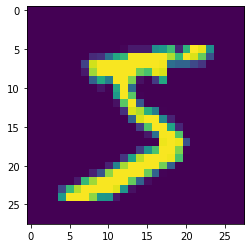

target: 5 predicted: 5


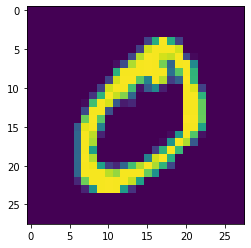

target: 0 predicted: 0


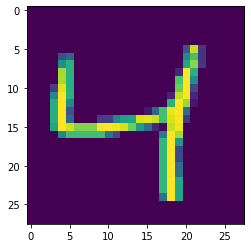

target: 4 predicted: 4


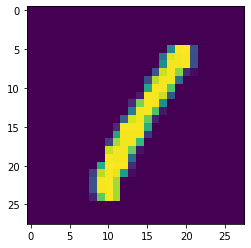

target: 1 predicted: 1


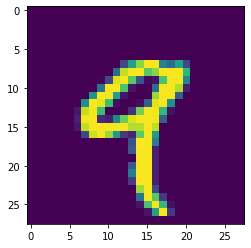

target: 9 predicted: 9


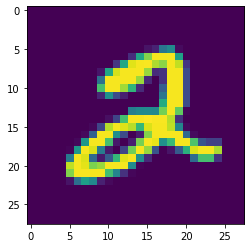

target: 2 predicted: 2


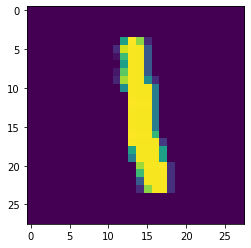

target: 1 predicted: 1


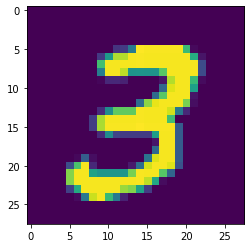

target: 3 predicted: 3


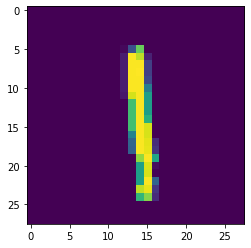

target: 1 predicted: 1


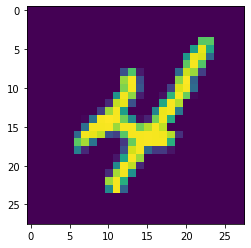

target: 4 predicted: 4


In [0]:
for i in range(10):
    img, target = ds[i]
    plt.imshow(img[0])
    plt.show()
    x = img.view(1,-1).numpy()
    res = mm(x)[0]
    pred = np.argmax(res)
    print(f'target: {target} predicted: {pred}' )

In [0]:
fig = plt.figure()
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.tight_layout()
  plt.imshow(ds.train[i], cmap='gray', interpolation='none')
  plt.title("Digit: {}".format(y_train[i]))
  plt.xticks([])
  plt.yticks([])

Text(0.5, 1.0, 'Pixel Value Distribution')

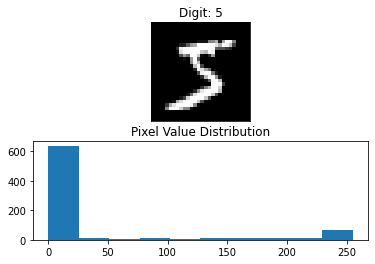

In [0]:
fig = plt.figure()
plt.subplot(2,1,1)
plt.imshow(X_train[0], cmap='gray', interpolation='none')
plt.title("Digit: {}".format(y_train[0]))
plt.xticks([])
plt.yticks([])
plt.subplot(2,1,2)
plt.hist(X_train[0].reshape(784))
plt.title("Pixel Value Distribution")

In [0]:
# Shape before we reshape and normalize
print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)
print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)

# build the input vector from the 28x28 pixels
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# normalize the data
X_train /= 255
X_test /= 255

# print the final input shape
print("Train matrix shape", X_train.shape)
print("Test matrix shape", X_test.shape)

X_train shape (60000, 28, 28)
y_train shape (60000,)
X_test shape (10000, 28, 28)
y_test shape (10000,)
Train matrix shape (60000, 784)
Test matrix shape (10000, 784)


In [0]:
dir(ds)

['__add__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_check_exists',
 '_format_transform_repr',
 '_repr_indent',
 'class_to_idx',
 'classes',
 'data',
 'download',
 'extra_repr',
 'processed_folder',
 'raw_folder',
 'resources',
 'root',
 'target_transform',
 'targets',
 'test_data',
 'test_file',
 'test_labels',
 'train',
 'train_data',
 'train_labels',
 'training_file',
 'transform',
 'transforms']

In [0]:
train = ds.data

In [0]:
type(train)

torch.Tensor